In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models import ResNeSt
from torchvision import transforms
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [3]:
artifact_path = Path("../../artifacts/resnest")
data_path = Path("../../data/animal10")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = len(dataset.classes)

In [9]:
dataset.classes

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

In [10]:
len(dataset)

26179

gallina


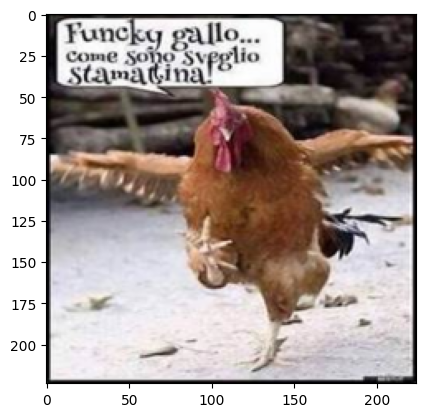

In [11]:
import random
demo_img, demo_label = dataset[random.randint(0, len(dataset))]
print(dataset.classes[demo_label])
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [12]:
model = ResNeSt(output_size=num_class, num_layer=50).to(device)

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                                       Param #
ResNeSt                                                      --
├─Sequential: 1-1                                            --
│    └─ConvBnRelu: 2-1                                       --
│    │    └─Conv2d: 3-1                                      9,408
│    │    └─BatchNorm2d: 3-2                                 128
│    │    └─ReLU: 3-3                                        --
│    └─MaxPool2d: 2-2                                        --
├─Sequential: 1-2                                            --
│    └─ResBlock: 2-3                                         --
│    │    └─BottleNeck: 3-4                                  64,576
│    │    └─ConvBnRelu: 3-5                                  16,896
│    └─ResBlock: 2-4                                         --
│    │    └─BottleNeck: 3-6                                  76,864
│    │    └─Identity: 3-7                                    --
│    └─ResBlock: 2-

# training

In [14]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [15]:
epoches = 10
acc_iters = 64 // BATCH_SIZE

In [16]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [17]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 1636/1636 [04:34<00:00,  5.96it/s]


epoch 1 : 0.11689905895826505


100%|██████████| 1636/1636 [04:29<00:00,  6.08it/s]


epoch 2 : 0.0967321864563817


100%|██████████| 1636/1636 [04:22<00:00,  6.22it/s]


epoch 3 : 0.09700742611675216


100%|██████████| 1636/1636 [04:28<00:00,  6.09it/s]


epoch 4 : 0.09660135008267202


100%|██████████| 1636/1636 [04:33<00:00,  5.98it/s]


epoch 5 : 0.08985973429390227


100%|██████████| 1636/1636 [04:21<00:00,  6.25it/s]


epoch 6 : 0.08365915298079366


100%|██████████| 1636/1636 [04:28<00:00,  6.10it/s]


epoch 7 : 0.08340338167841467


100%|██████████| 1636/1636 [04:21<00:00,  6.26it/s]


epoch 8 : 0.08362857769937926


100%|██████████| 1636/1636 [04:31<00:00,  6.03it/s]


epoch 9 : 0.07542948608575867


100%|██████████| 1636/1636 [04:20<00:00,  6.29it/s]

epoch 10 : 0.06798055230851642


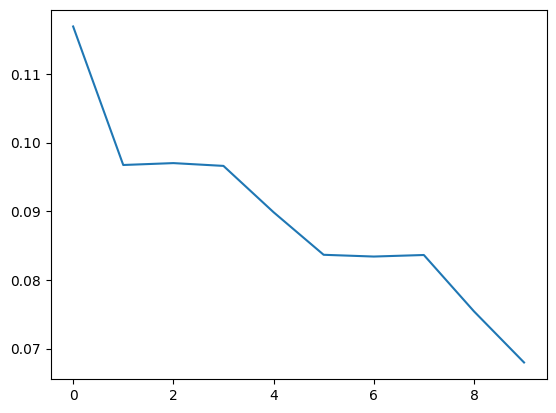

In [18]:
plt.plot(training_loss)

# inference

In [19]:
test_preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [20]:
test_dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [21]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [22]:
evaluator = ClassificationEvaluator(num_class, device)

In [23]:
confusion_matrix = IncrementalConfusionMatrix(num_class)

model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        img = img.to(device)
        
        output = model(img)
        output = output.detach().cpu()

        output = output.argmax(dim=1)
        confusion_matrix.update(label, output)

100%|██████████| 1637/1637 [02:40<00:00, 10.18it/s]


In [24]:
print(confusion_matrix)

[[3220  316  126   61  140  484   11  106  137  262]
 [ 336 1656  252   49   69   29   12  105   80   35]
 [  91  171 1008    7   20   12    2   44   23   68]
 [  33   15    3 1687    9   13    0    1  307   44]
 [ 170   86   33   94 2388   32    2   51  135  107]
 [ 463    8   22   27   31  737    3   30  140  207]
 [ 256  917  151   14   28   13  140  294   25   28]
 [ 166  196  226    9   76   56   31  904   52  104]
 [ 129   14   14  218   15  154    0   25 4045  207]
 [ 151   15   48   42   48  129    0   54  196 1179]]


In [25]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.6621427102611557
cavallo   : 0.6313381624094548
elefante  : 0.6970954356846473
farfalla  : 0.7987689393939394
gallina   : 0.7708198837959974
gatto     : 0.44184652278177455
mucca     : 0.07502679528403002
pecora    : 0.4967032967032967
ragno     : 0.8390375440779921
scoiattolo: 0.6331901181525241


In [26]:
per_class_acc.mean()

0.6045969408544811

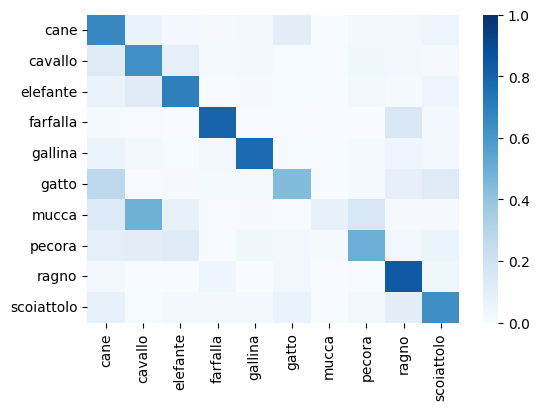

In [27]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [34]:
# image from internet
import requests
from io import BytesIO
from PIL import Image

demo_url = "http://t2.gstatic.com/licensed-image?q=tbn:ANd9GcSFoiMCj_B7I2ML4tMYIbrcSgD9gBkp-G1JVfYz8R5xtL76jjcXyhY92BwcFNKCSxCU1NwmZ5XfIAO1VCF7WCM" # cow
# demo_url = "http://t0.gstatic.com/licensed-image?q=tbn:ANd9GcRgs4mxH44aRwV3qnlSmBlnP2u4pEDu8gatItCeqvXEb3yUol302ClE9ujMszbxXiyPZopDy-3i9EzcjjLNdTI" # horse
img = Image.open(BytesIO(requests.get(demo_url).content))
img = test_preprocess(img).unsqueeze(0).to(device)

In [35]:
model.eval()
with torch.no_grad():
    prediction = model(img).detach().cpu()
    print(dataset.classes[prediction.argmax()])
    # print(dataset.classes[sample[1]])

cavallo


In [36]:
model_path = artifact_path / 'resnest50.pth'

In [37]:
torch.save(model.state_dict(), model_path)

In [38]:
get_file_size(model_path)

'97.43MB'

In [39]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>